In [222]:
# Do we actually need all this using statements?
# we need ITensor as we use some functions direclty in the notebook, same for progressmeter
# Potentially, they are automatically included when loading RandomMeas ?
using Revise
using ITensors, ITensorMPS
using RandomMeas
using ProgressMeter # Shall we move it to some script file? The user does not need it explicitly?

## Shallow Shadows 

### Introduction
For a given ensemble of random unitaries $\{u\}$, the measurement or shadow channel $\mathcal{M}$ is defined as $\rho \rightarrow \mathcal{M}(\rho)=\mathbb{E}_u \left[  \sum_s \bra{s}\rho u^\dagger \ket{s}u^\dagger \ket{s}\bra{s}u\right]$ where $\mathbb{E}_u$ denotes the average over the random unitary ensemble. For certain ensembles, in particular local (single-qubit) and global (N-qubit) unitaries from unitary 2-designs, the channel and its inverse $\mathcal{M}^{-1}$ can be computed analytically (Huang et al., Nat. Phys. 2020). We can then use to construct classical shadows for arbitrary input states $\rho$: $\hat{\rho}=\mathcal{M}^{-1}(u^\dagger \ket{s}\bra{s}u)$ where $s$ is the outcome bitstring  of a single computational basis measurement performed on $u\rho u^\dagger$.

For more general ensembles of random unitaries, we need to learn the channel $\mathcal{M}$, then invert it to form shadows and obtain a randomized measurement protocol.

This notebook illustrates this for case of random unitaries formed by shallow random quantum circuits [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027), [Akhtar et al., Quantum 7, 1026 (2023)](https://quantum-journal.org/papers/q-2023-06-01-1026), [Bertoni et al, arxiv:2209.12924](https://arxiv.org/abs/2209.12924) and [Hu et al., arXiv:2402.17911](https://arxiv.org/abs/2402.17911). Importantly, we use the property that shallow random quantum circuits are locally scrambling circuits. This allows us to learn a representation of the channel from evaluating its action on single initial product state  [Hu et al., PRR 5, 023027 (2023)](https://doi.org/10.1103/PhysRevResearch.5.023027).

### Learning depolarization vectors
It has been proven with local invariant unitaries 
$$\mathcal{M}(\rho)=\sum_v c_v (\rho_v\otimes 1_{\bar{v}}/2^{|\bar{v}|})$$
with $v$ summed over $2^N$ bitstrings $v_1,v_2,\dots,v_N$, and $\rho_v$ described the subsystem density matrix on sites $i$ such that $s_i=1$.
The "depolarization vector" $c_v$ fully specifies the channel $\mathcal{M}(\cdot)$.

Let us consider an initial state $\rho_0=\ket{0}$. We have the equality 
$$c_v=\mathrm{tr}(\mathcal{M}(\rho_0)O_v)$$
with $O_v=\bigotimes_{i}\left((\ket{0}\bra{0}-\ket{1}\bra{1})\delta_{v=1}+2(\ket{1}\bra{1})\delta_{s=0}\right)$.

 Therefore a single initial state fully specifies $c_v$ and therefore the channel $\mathcal{M}(\cdot)$.

To learn the vector $c_v$, first we recall that 
$$\mathcal{M}(\rho_0)=E_U\left[\sum_s \braket{s|U\rho_0U^\dag|s} U^\dag \ket{s}\bra{s} U \right]$$
 
 Therefore $c_v=E_U[c_v(U)]$, with 
 $$c_v(U)=\sum_s \braket{s|U\rho_0U^\dag|s} \braket{s|U O_v U^\dag|s}$$

 For a list of random unitaries $U$, these depolarization vectors $c_v(U)$ can be computed as Matrix-Product-States (MPS) by evolving $\rho_0$ and $O_v$ and contracting the physical indices $s$. For instance, with a random circuit of depth 2, this is done as follows

In [262]:
Nu = 2000 # Number of unitaries
N = 8
ξ = siteinds("Qubit", N;addtags="output")

random_unitaries = Vector{Vector{ITensor}}()
depth = 2
for r in 1:Nu # For each unitary u, we generate a random circuit of depth 2
    push!(random_unitaries,random_circuit(ξ,depth)) 
end
cu = get_depolarization_vectors(random_unitaries,ξ);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


### Fitting the average depolarization vector as an MPS

In order to obtain the average depolarization vector $c_v\approx 1/{N_u}\sum_U c_v(U)$ as a compressed matrix product state (MPS), we adapt a fitting algorithm[T Baumgratz et al 2013 New J. Phys. 15 125004](https://iopscience.iop.org/article/10.1088/1367-2630/15/12/125004). We minimize the cost function $\mathcal{C}=||c_v-1/N_U\sum_U c_{v}(U)||^2_2-||1/N_U\sum_U c_{v}(U)||^2_2$. The compression algorithm updates each tensor sequentially over a finite number of sweeps.

In [263]:
nsweeps = 6 # Number of sweeps for the fitting 
χ = 4 # Bond dimension of the mpo fitted to output state of the measurement channel applied to \psi_0
c = fit_depolarization_vector(cu,χ,nsweeps);

Cost function -0.16564115395303342
Cost function -0.42468764216730986


Progress:  33%|█████████████▋                           |  ETA: 0:00:15

Cost function -0.4246885305323508


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress:  50%|████████████████████▌                    |  ETA: 0:00:12

Cost function -0.42468900049677205


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:08

Cost function -0.4246895566259987


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:04

Cost function -0.4246903011131333


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Cost function -0.4246906304648626


### Inverting the channel

For local invariant unitaries, we can assume the following functional form for the inverse channel
$$\mathcal{M}^{-1}(\sigma)=\sum_v d_v (\sigma_v\otimes 1_{\bar{v}}/{2^{|v|}})$$
with $d_v$ parametrized as MPS.

This we want to parametrize the vector $d_v$ such that, for all $\rho$, 
$$\mathcal{M}^{-1}\mathcal{M}(\rho)=\sum_{v,v'}c_vd_{v'}(\rho_{v||v'}\otimes 1_{\bar{v||v'}}/{2^{|v||v'|}})=\rho$$

This can be done by minimizing
$$\mathcal{C}'=||\sum_{v''}(\sum_{v,v'}c_vd_{v'}\delta_{v'',v||v'})-\delta_{v'',0}||^2$$

This minimization is performed by writting $\mathcal{C}'$ as a result of a tensor contraction, whose gradients with respects to the tensors of an MPS $d_v$ can be evaluated by automatic differentations using the package Zygote. The algorithm proceeds by a sequence of sweeps, updating each local tensor sequentially

In [264]:
d = get_inverse_depolarization_vector(c,χ,nsweeps);

sweep 1 cost function 0.1683374786565781
sweep 2 cost function 0.05014146046967971
sweep 3 cost function 0.039280011632192524
sweep 4 cost function 0.03630207920117645
sweep 5 cost function 0.03313795099504169
sweep 6 cost function 0.028762908205832383


## Simulated experiment
We are ready to perform an experiment on a unknown state $\psi$, build shadows as MPO and estimate expectation values.

In [265]:
circuit = random_circuit(ξ,depth)
ψ0 = MPS(ξ,["Dn" for n in 1:N]  ) 
ψ = apply(circuit,ψ0); # We construct some random pure state \psi, our simulated experimental (unknown) state

We perform random measurements in a simulated quantum device.

In [266]:
NM = 100
measurement_data = Array{Int,3}(undef,Nu,NM,N)
@showprogress dt=1 for r in 1:Nu
    measurement_data[r,:,:] = get_RandomMeas(ψ,random_unitaries[r],NM) #data acquisition in simulated quantum device
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


We aim to estimate XX correlations. We construct the corresponding MPOs and compute the exact expectation values.

In [267]:
O = Vector{MPO}()
for i in 1:N-1
    ampo = AutoMPO()
    ampo .+= "X", i,"X",i+1
    push!(O,MPO(ampo,ξ))
end

O_exact = Vector{Float64}()
for o in O
    push!(O_exact,real(inner(ψ',o,ψ)))
end

For a given unitary, we know that the correspond shadow estimator for an observable $O$ can be written as 
$$O_e = \sum_s P_U(s) \mathrm{tr}(\mathcal{M}^{-1}(U^\dag\ket{s}\bra{s}U) O)=\sum_s P_U(s) \braket{s|U\mathcal{M}^{-1}(O)U^\dag|s}$$
where $P_U(s)$ is the estimated Born probability, and we have used the fact that $\mathcal{M}^{-1}$ is self-adjoint. This is implemented as follows:

In [268]:
O_est = zeros(Float64,N-1);
@showprogress dt=1 for i in 1:N-1
    Q = apply_inverse_channel(O[i],d) #we calculate Q=M^-1(O)
    for r in 1:Nu
        Qu = apply(random_unitaries[r],Q;apply_dag=true)#we calculate UQU^dag 
        Qu_s = get_Born(Qu) #we calculate <s|UQU^dag|s> 
        P = get_Born(measurement_data[r,:,:],ξ) 
        O_est[i] += real((P*Qu_s)[])/Nu
    end
end
@show O_est

Progress: 100%|█████████████████████████████████████████| Time: 0:03:30


O_est = [0.187380497050822, -0.26455096649217263, -0.07466434382539182, -0.4335323895702595, 0.0146481810606115, -0.16205925224635645, 0.3159610332137529]


7-element Vector{Float64}:
  0.187380497050822
 -0.26455096649217263
 -0.07466434382539182
 -0.4335323895702595
  0.0146481810606115
 -0.16205925224635645
  0.3159610332137529

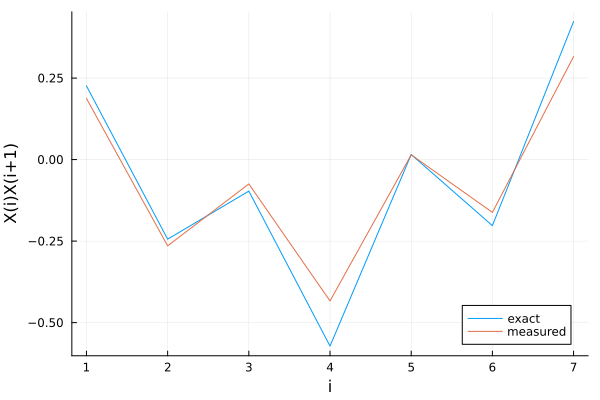

In [269]:
using Plots
plot(O_exact,label="exact")
plot!(O_est,label="measured")
#plot!(O_est_2,label="measured original")

xlabel!("i")
ylabel!("X(i)X(i+1)")